# Few-shot learning - Omniglot - Fellowship.ai
This notebook is my personal project to the few-shot learning challenge from [Fellowship.ai](https://fellowship.ai/challenge/) with the following goal:
> Omniglot, the “transpose” of MNIST, with 1623 character classes, each with 20 examples.  Build a few-shot classifier with a target of <35% error.

I managed to reach an error rate of 8% on a 20-way classification corresponding to the current state of the art model.

# Abstract


### The Omniglot dataset
*Dataset reference:* [Link](https://github.com/brendenlake/omniglot)
> Lake, B. M., Salakhutdinov, R., and Tenenbaum, J. B. (2015). Human-level concept learning through probabilistic program induction. Science, 350(6266), 1332-1338.

The Omniglot dataset is often considered as the transpose of the MNIST dataset. While the latter contains only 10 classes with a training set of 60000 examples, Omniglot contains an important number of classes (1623 different handwritten characters from 50 different alphabets) with only a low number of examples (20) for each, making it an ideal dataset for few-shot learning problems.

### Few-shot learning
Whereas, lots of deep learning projects are based on a huge number of training examples to be trained, few-shot learning is  based only on a few one. This approach is much closer to the one experienced by humans. We are able to memorize and recognize objects we have never seen before from a few number of examples. Then for each new encounter with these types of object we can classify them in an accurate and easy way.

### Approach
The approach I used for this challenge is essentially based on a triplet-loss model.
For each image one embedding of size 64 was created using a ResNet-like architecture (current state of the art CNN architecture) combined to a triplet-loss  model.

# Content
* A/ Libraries and Images Path

* B/ Exploratory Data Analysis

* C/ Preprocessing

* D/ Triplet loss Neural Network Architecture

* E/ Training Procedure

* F/ Model Evaluation

## A/ Libraries and Images Path

#### Import useful libraries

In [2]:
import os
import glob

import tensorflow as tf
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, concatenate,AveragePooling2D, Lambda, Add
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
import h5py

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### PATH

We indicate the PATH of the training and evaluation examples.

In [3]:
PATH = "images_background" #Training images path

PATH_TEST = "images_evaluation" #Validation and test images path

The pictures are divided into two folders :
The evaluation folder 

## B/ Exploratory Data Analysis

We have a look at the list of all alphabets contained in the training set, and their total number.
### 0.Alphabets in Training and Evaluation set
#### a) Images_background

In [4]:
alph_type = np.array(os.listdir(PATH)) #Give the different types of alphabet in our training data
print(f"List of the different alphabets:\n {alph_type}")
print(f"\nNumber of different alphabets: {len(alph_type)}")

List of the different alphabets:
 ['Syriac_(Estrangelo)' 'Armenian' 'Latin' 'Hebrew' 'Tifinagh'
 'Burmese_(Myanmar)' 'Japanese_(katakana)' 'Anglo-Saxon_Futhorc'
 'Ojibwe_(Canadian_Aboriginal_Syllabics)' 'Asomtavruli_(Georgian)'
 'Blackfoot_(Canadian_Aboriginal_Syllabics)' 'Japanese_(hiragana)' 'Greek'
 'Futurama' 'Alphabet_of_the_Magi' 'Grantha' 'Bengali' 'N_Ko' 'Balinese'
 'Gujarati' 'Early_Aramaic' 'Inuktitut_(Canadian_Aboriginal_Syllabics)'
 'Mkhedruli_(Georgian)' 'Sanskrit' 'Korean' 'Braille' 'Tagalog'
 'Malay_(Jawi_-_Arabic)' 'Arcadian' 'Cyrillic']

Number of different alphabets: 30


To create our validation set, we will split our background images into 2 sets :
- Training set : Containing the first 27 alphabets in background_images
- Validation set: Containing the last 3 alphabets in background images
The validation set needs to have characters completely different from the training set. As the testing set is made of characters from alphabets totally different from our training set, we choose a validation set containing different alphabets from the training set

In [5]:
#First shuffle the alphabets
np.random.shuffle(alph_type)

alph_type_train = alph_type[:27]
alph_type_val = alph_type[27:]

print(f"List of the different alphabets in training set:\n {alph_type_train}")
print(f"\nNumber of different alphabets in training set: {len(alph_type_train)}")
print(f"\nList of the different alphabets in validation set:\n {alph_type_val}")
print(f"\nNumber of different alphabets in validation set: {len(alph_type_val)}")

List of the different alphabets in training set:
 ['Ojibwe_(Canadian_Aboriginal_Syllabics)' 'Greek' 'Tifinagh' 'Armenian'
 'Japanese_(katakana)' 'Sanskrit' 'Syriac_(Estrangelo)' 'Gujarati'
 'Tagalog' 'Mkhedruli_(Georgian)' 'Korean' 'Anglo-Saxon_Futhorc'
 'Arcadian' 'Futurama' 'Early_Aramaic'
 'Inuktitut_(Canadian_Aboriginal_Syllabics)' 'Bengali' 'N_Ko'
 'Alphabet_of_the_Magi' 'Cyrillic' 'Grantha'
 'Blackfoot_(Canadian_Aboriginal_Syllabics)' 'Japanese_(hiragana)'
 'Balinese' 'Hebrew' 'Asomtavruli_(Georgian)' 'Burmese_(Myanmar)']

Number of different alphabets in training set: 27

List of the different alphabets in validation set:
 ['Latin' 'Malay_(Jawi_-_Arabic)' 'Braille']

Number of different alphabets in validation set: 3


#### b) Test set

In [6]:
alph_type_test = np.array(os.listdir(PATH_TEST)) #Give the different types of alphabet in our evaluation data
print(f"List of the different alphabets:\n {alph_type_test}")
print(f"\nNumber of different alphabets: {len(alph_type_test)}")

List of the different alphabets:
 ['Tibetan' 'Glagolitic' 'Atlantean' 'Aurek-Besh' 'Mongolian' 'Keble'
 'Kannada' 'Old_Church_Slavonic_(Cyrillic)' 'Tengwar' 'Manipuri'
 'Gurmukhi' 'Avesta' 'Oriya' 'Atemayar_Qelisayer' 'Angelic' 'Sylheti'
 'ULOG' 'Malayalam' 'Syriac_(Serto)' 'Ge_ez']

Number of different alphabets: 20


### 1.Number of characters per alphabets
We then check the number of character for each alphabets.
#### a) Training set

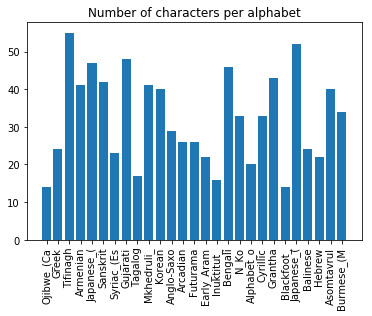


The maximum number of different character for one alphabet is 55
The minimum number of different character for one alphabet is 14
The total number of different character is 872


In [7]:
alph_num_char_train = {alphabet:len(os.listdir(f'{PATH}/{alphabet}')) for alphabet in alph_type_train}
num_of_char_train = alph_num_char_train.values()

plt.bar(range(len(alph_type_train)),num_of_char_train)
plt.xticks(range(len(alph_type_train)), [alph[:10] for alph in alph_type], rotation=90)
plt.title('Number of characters per alphabet')
plt.show()

print(f'\nThe maximum number of different character for one alphabet is {max(num_of_char_train)}')
print(f'The minimum number of different character for one alphabet is {min(num_of_char_train)}')
total_char_train = sum(num_of_char_train)
print(f'The total number of different character is {total_char_train}')

#### b) Validation set

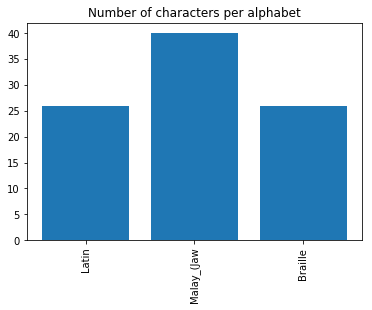


The maximum number of different character for one alphabet is 40
The minimum number of different character for one alphabet is 26
The total number of different character is 92


In [8]:
alph_num_char_val = {alphabet:len(os.listdir(f'{PATH}/{alphabet}')) for alphabet in alph_type_val}
num_of_char_val = alph_num_char_val.values()

plt.bar(range(len(alph_type_val)),num_of_char_val)
plt.xticks(range(len(alph_type_val)), [alph[:10] for alph in alph_type_val], rotation=90)
plt.title('Number of characters per alphabet')
plt.show()

print(f'\nThe maximum number of different character for one alphabet is {max(num_of_char_val)}')
print(f'The minimum number of different character for one alphabet is {min(num_of_char_val)}')
total_char_val = sum(num_of_char_val)
print(f'The total number of different character is {total_char_val}')

#### c) Test set

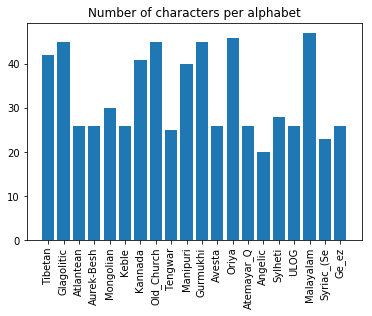


The maximum number of different character for one alphabet is 47
The minimum number of different character for one alphabet is 20
The total number of different character is 659


In [9]:
alph_num_char_test = {alphabet:len(os.listdir(f'{PATH_TEST}/{alphabet}')) for alphabet in alph_type_test}
num_of_char_test = alph_num_char_test.values()

plt.bar(range(len(alph_type_test)),num_of_char_test)
plt.xticks(range(len(alph_type_test)), [alph[:10] for alph in alph_type_test], rotation=90)
plt.title('Number of characters per alphabet')
plt.show()

print(f'\nThe maximum number of different character for one alphabet is {max(num_of_char_test)}')
print(f'The minimum number of different character for one alphabet is {min(num_of_char_test)}')
total_char_test = sum(num_of_char_test)
print(f'The total number of different character is {total_char_test}')

### 2.Number of pictures per character
#### a) Training set

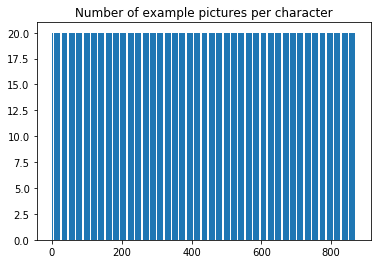

20 20
The total number of different pictures is 17440


In [10]:
alph_num_char_ex_train = {}
for alphabet in alph_type_train:
    char_list_train = os.listdir(f'{PATH}/{alphabet}')
    for char in char_list_train:
        alph_num_char_ex_train[(alphabet,char)] = len(os.listdir(f'{PATH}/{alphabet}/{char}'))

num_of_example_train = alph_num_char_ex_train.values()

plt.bar(range(len(alph_num_char_ex_train)),num_of_example_train)
plt.title('Number of example pictures per character')
plt.show()

total_example_train = sum(num_of_example_train) 
print(min(num_of_example_train),max(num_of_example_train))
print(f'The total number of different pictures is {total_example_train}')

#### b) Validation set

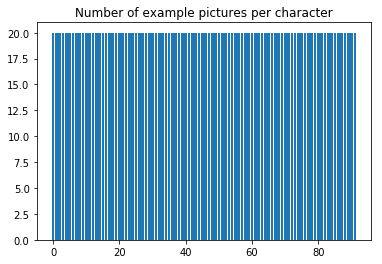

20 20
The total number of different pictures is 1840


In [11]:
alph_num_char_ex_val = {}
for alphabet in alph_type_val:
    char_list_val = os.listdir(f'{PATH}/{alphabet}')
    for char in char_list_val:
        alph_num_char_ex_val[(alphabet,char)] = len(os.listdir(f'{PATH}/{alphabet}/{char}'))

num_of_example_val = alph_num_char_ex_val.values()

plt.bar(range(len(alph_num_char_ex_val)),num_of_example_val)
plt.title('Number of example pictures per character')
plt.show()

total_example_val = sum(num_of_example_val) 
print(min(num_of_example_val),max(num_of_example_val))
print(f'The total number of different pictures is {total_example_val}')

#### c) Test set

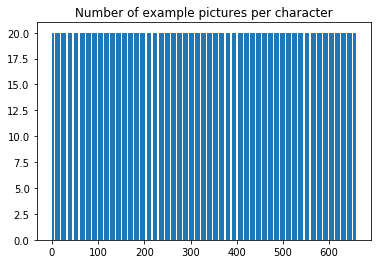

20 20
The total number of different pictures is 13180


In [12]:
alph_num_char_ex_test = {}
for alphabet in alph_type_test:
    char_list_test = os.listdir(f'{PATH_TEST}/{alphabet}')
    for char in char_list_test:
        alph_num_char_ex_test[(alphabet,char)] = len(os.listdir(f'{PATH_TEST}/{alphabet}/{char}'))

num_of_example_test = alph_num_char_ex_test.values()

plt.bar(range(len(alph_num_char_ex_test)), num_of_example_test)
plt.title('Number of example pictures per character')
plt.show()

total_example_test = sum(num_of_example_test) 
print(min(num_of_example_test),max(num_of_example_test))
print(f'The total number of different pictures is {total_example_test}')

We can observe that each character have 20 examples(pictures) and that our training, validation and test sets are well balanced. For our training we will consider that each character is an independent class.

## C/ Preprocessing

### 1.Add a label for each character


For each picture in our training set we set a corresponding integer which allow us to determine the corresponding character. Here an integer is sufficient as we are not really interested in knowing from which alphabet an image is coming from and as we don't have need to know the character name. All characters can easily be considered as independant.

#### a) Training set

In [13]:
Y_train = np.array([i//20+1 for i in range(total_example_train)])
Y_train.shape

(17440,)

We reshape, our data to have the number of channel including (here is 1).

In [14]:
Y_train=Y_train.reshape(*Y_train.shape,1)
Y_train.shape

(17440, 1)

#### b) Validation set

In [15]:
Y_val = np.array([i//20+1 for i in range(total_example_val)])
Y_val=Y_val.reshape(*Y_val.shape,1)
Y_val.shape

(1840, 1)

#### c) Test set

In [16]:
Y_test = np.array([i//20+1 for i in range(total_example_test)])
Y_test=Y_test.reshape(*Y_test.shape,1)
Y_test.shape

(13180, 1)

### 2.Convert images to datafile

We first retrieve the path for each picture in the dataset.

In [17]:
#Train set
trainPath = []
for alphabet in alph_type_train:
    trainPath += glob.glob(f"{PATH}/{alphabet}/*/*.png")
trainPath[0:5]

['images_background/Ojibwe_(Canadian_Aboriginal_Syllabics)/character11/0847_16.png',
 'images_background/Ojibwe_(Canadian_Aboriginal_Syllabics)/character11/0847_19.png',
 'images_background/Ojibwe_(Canadian_Aboriginal_Syllabics)/character11/0847_20.png',
 'images_background/Ojibwe_(Canadian_Aboriginal_Syllabics)/character11/0847_01.png',
 'images_background/Ojibwe_(Canadian_Aboriginal_Syllabics)/character11/0847_15.png']

In [18]:
#Validation set
valPath = []
for alphabet in alph_type_val:
    valPath += glob.glob(f"{PATH}/{alphabet}/*/*.png")

In [19]:
#Test set
testPath = glob.glob(f"{PATH_TEST}/*/*/*.png")

#### A few examples

We print some random images of the dataset, convert them to arrays and resize them.
We decide to resize to the size of 64x64 pixels, which will help the model to be easier to train. Moreover, 64x64 seems a reasonable size still allowing us and the machine to recognize the character.
#### Training set

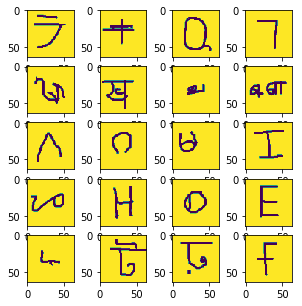

In [20]:
SZ=64 #Dimension of the output image expected

#Dimensions of the grill of sample pictures
columns = 4
rows = 5

fig=plt.figure(figsize=(5, 5))

#Print 20 random examples of images
list_example = np.random.randint(total_example_train, size = columns*rows)
pos=0
for i in list_example:
    pos+=1
    img = mpimg.imread(trainPath[i])
    img = resize(img, (SZ,SZ), mode='reflect')
    fig.add_subplot(rows, columns, pos)
    plt.imshow(img)
plt.show()

All images seems clear and well centered. We can also observe that they only have one channel and no RGB.

#### Image conversion
We convert all training images into arrays and resize them all to the 64x64 format. We concatenate all arrays into the variable X_train

#### a) Training set

In [21]:
#Train set
#Transform in array and resize all 19280 images 
X_train = np.array([resize(mpimg.imread(i), (SZ,SZ), mode='edge') for i in trainPath])
X_train.shape

(17440, 64, 64)

In our CNN blocks later we will need to define a number of channel. Here pictures only have one channel. So we will reshape the pictures to take in account that they have one channel.

In [22]:
channel_sz = 1 #number of channel
X_train= X_train.reshape(*X_train.shape, channel_sz)
X_train.shape

(17440, 64, 64, 1)

#### b) Validation set

In [23]:
X_val = np.array([resize(mpimg.imread(i), (SZ,SZ), mode='edge') for i in valPath])
X_val= X_val.reshape(*X_val.shape, channel_sz)
X_val.shape

(1840, 64, 64, 1)

#### b) Evaluation set

The same process is done with the evaluation set

In [24]:
X_test = np.array([resize(mpimg.imread(i), (SZ,SZ), mode='edge') for i in testPath])
X_test= X_test.reshape(*X_test.shape, channel_sz)
X_test.shape

(13180, 64, 64, 1)

### 4.Triplet loss function

Our loss function is determined by the following triplet loss function.<br/>
The basic idea here is to take the embeddings of a triplet of pictures (Anchor, Positive, Negative) where :
* Anchor :  are the embeddings corresponding to our base image
* Positive : are the embeddings of another image corresponding to the same class as our Anchor 
* Negative : are the embeddings of an image which correspond to an image from a different class than our Anchor

The goal of the triplet loss is to minimize the distance between the embeddings of the Anchor and the Positive image (that we call the pos_dist), while it should maximize the distance between the embeddings of the Anchor and the Negative Image(neg_dist).
Thus triplet loss should maximize the difference between the pos_dis and neg_dis. If this difference if below 0, our model is accurate, while if the difference is above 0, we obtain a value for our loss to optimize.


Due to the way we define our triplet_loss we need to add an alpha term to insure that the difference between pos_dist and neg_dist is not zero. This also prevent the model from choosing the trivial values of zero embeddings for our 3 images.

The initial triplet loss is define as the sum of the difference between pos_dist and neg_dist over a mini-batch. Therefore it makes the loss value dependant of the mini batc size. Instead we choose to use the mean over a minibatch to keep a constant loss independent of mini batch size.
We also decide to divide by alpha to obtain a value non dependent of alpha.

In [25]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 64)
            positive -- the encodings for the positive images, of shape (None, 64)
            negative -- the encodings for the negative images, of shape (None, 64)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[:,0:64], y_pred[:,64:128], y_pred[:,128:196]
    
    #Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis = -1))
    #Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis = -1))
    #Subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(basic_loss,0))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    #Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0))/ alpha * 100
    
    return loss

We define our error rate by calculating the number of hard triplets over the total number of triplets. For the accuracy we simply take 1-error percentage.

In [26]:
def triplet_acc(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet accuracy
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 64)
            positive -- the encodings for the positive images, of shape (None, 64)
            negative -- the encodings for the negative images, of shape (None, 64)
    
    Returns:
    loss -- real number, value of the accuracy
    """
    
    anchor, positive, negative = y_pred[:,0:64], y_pred[:,64:128], y_pred[:,128:196]
    
    #Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis = -1)
    #Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis = -1)
    #Subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Count number of positive triplets (where triplet_loss > 0)
    hard_triplets = tf.to_float(tf.greater(basic_loss,alpha))
    num_hard_triplets = tf.reduce_sum(hard_triplets)
    #Count number of triplets
    all_triplets = tf.reduce_sum(tf.to_float(tf.greater(basic_loss,-10**10)))
    
    #Accuracy
    acc = 1 - num_hard_triplets/all_triplets
    
    return acc

### 5.Creation of valid triplets

The possible number of valid triplets in our training set is huge.
To be able to feed our model with only valid triplets, we will later build a generator for our training set based on a select. Therefore for the validation set, to be able to compare more accurately our models, we create a fixed number of valid triplets. There is no need here to create a generator as all the triplets can easily fit in memory.
For each (anchor, positive) couple of images we add a random negative anchor image.

In [27]:
def create_triplets(X, Y, num=1):
    """
    Create a list of valid triplets for each valid (anchor, positive) couple
    
    Arguments:
    X -- array of images
    Y -- array of classes corresponding to each image
    num -- number of negative images for each valid anchor and positive images - must be positive
           if num = 0, all possible valid couples are created
            For example : for one valid (A,P) couple we can select 'num' random N images. 
                          Thus 'num' triplets are created for this (A,P) couple
    
    Returns:
    (A,P,N) -- python tuple containing 3 arrays : 
            A -- the array for the anchor images, of shape (None, 64)
            P -- the array for the positive images, of shape (None, 64)
            N -- the array for the negative images, of shape (None, 64)
    """

    Y = Y.reshape(Y.shape[0],)
    A = []
    P = []
    N = []
    
    #We loop over all possible valid (A,P)
    for i in range(X.shape[0]):  
        list_pos = X[Y==Y[i]]
        for j in list_pos:
            #We provide a number 'num' of triplets for each valid (A,P)
            if num >=1:
                for k in range(num):
                    rand_num = np.random.randint(X.shape[0])
                    if np.array_equal(X[i],j) == False:
                        A.append(X[i])
                        P.append(j)
                        while np.array_equal(Y[rand_num], Y[i]):
                            rand_num = np.random.randint(X.shape[0])
                        N.append(X[rand_num])
            if num == 0:
                for k in range(X.shape[0]):
                    if np.array_equal(X[i],j) == False:
                        if np.array_equal(Y[i],Y[k]) == False:
                            A.append(X[i])
                            P.append(j)
                            N.append(X[k])
    
    A = np.array(A)
    P = np.array(P)
    N = np.array(N)
    
    return (A, P, N)

In [28]:
triplets_list_val = create_triplets(X_val, Y_val, 1)
print([i.shape for i in triplets_list_val])

[(34958, 64, 64, 1), (34958, 64, 64, 1), (34958, 64, 64, 1)]


This gives us a number of 25080 valid triplets for the validation set. This number of images give us a reasonable indication on the accuracy.

## D/ Triplet loss Neural Network architecture

The Triplet loss Neural Network is composed of 2 parts :
* a Convolutional Neural Network(CNN) which transforms an input image into an embedding(vector of features describing the whale). The same CNN, with the same weights are used one valid triplet of images.
* a global model which will concatenante all the embeddings

### 1.Embedding Model

The embedding model that we use is based on the version 2 of ResNet model because of its ability to make deeper networks more effective and facilitating the learning process. Moreover it is still considered as a current State of the Art Model. Therefore we won't use the original model because our input images here are only of size 64x64 instead of (229x229) and moreover as our problem is easier with less channels and features, and because of our limited computational ressouces we will create a small variant of this model.

The embedding Model is composed of 4 blocks :
* Block 1 - 64x64
* Block 2 - 32x32
* Block 3 - 16x16
* Block 4 - 8x8

Finally, a final averaging pooling will be used, then flatten and processed in a dense layer to obtain our embeddings of size 64.

In [29]:
def EmbModel(input_shape, l2):
    regul  = regularizers.l2(l2)
    kwargs = {'padding':'same', 'kernel_regularizer':regul,'kernel_initializer':'he_normal'}

    inp = Input(input_shape) # 64x64x1
    x   = Conv2D(32, (3,3), strides=1, **kwargs)(inp) #32x32x64
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    #Stage 0 / resblock 0
    y   = Conv2D(32, (1,1), strides=1, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(32, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(64, (1,1), strides=1, **kwargs)(y)
    
    x   = Conv2D(64, (1,1), strides=1, **kwargs) (x)
    x   = Add()([x,y])
    
    #Stage 0 / resblock 1
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    y   = Conv2D(32, (1,1), strides=1, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(32, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(64, (1,1), strides=1, **kwargs)(y)
    
    x   = Add()([x,y])
    
    #Stage 1 / resblock 0
    y   = Conv2D(64, (1,1), strides=2, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(64, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(128, (1,1), strides=1, **kwargs)(y)
    
    x   = Conv2D(128, (1,1), strides=2, **kwargs) (x)
    x   = Add()([x,y])
    
    #Stage 1 / resblock 1
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    y   = Conv2D(64, (1,1), strides=1, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(64, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(128, (1,1), strides=1, **kwargs)(y)
    
    x   = Add()([x,y])
    
    #Stage 2 / resblock 0
    y   = Conv2D(128, (1,1), strides=2, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(128, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(256, (1,1), strides=1, **kwargs)(y)
    
    x   = Conv2D(256, (1,1), strides=2, **kwargs) (x)
    x   = Add()([x,y])
    
    #Stage 2 / resblock 1
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    y   = Conv2D(128, (1,1), strides=1, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(128, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(256, (1,1), strides=1, **kwargs)(y)
    
    x   = Add()([x,y])
    
    #Stage 3 / resblock 0
    y   = Conv2D(256, (1,1), strides=2, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(256, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(512, (1,1), strides=1, **kwargs)(y)
    
    x   = Conv2D(512, (1,1), strides=2, **kwargs) (x)
    x   = Add()([x,y])
    
    #Stage 2 / resblock 1
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    y   = Conv2D(256, (1,1), strides=1, **kwargs)(x)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(256, (3,3), strides=1, **kwargs)(y)
    
    y   = BatchNormalization()(y)
    y   = Activation('relu')(y)
    y   = Conv2D(512, (1,1), strides=1, **kwargs)(y)
    
    x   = Add()([x,y])
    
    #Final
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    x   = AveragePooling2D(pool_size=8)(x)
    x   = Flatten()(x)
    x = Dense (64, activation ='tanh',kernel_initializer='he_normal') (x)

    
    ##Create model
    model = Model(inputs = inp, outputs = x, name='EmbModel')
    
    return model

### 2.Global model

The global model will use 3 instances of our embedding model for each images of our triplets. All the weights between the 3 models are shared. Then we finally backpropagate and update these weights by using our triplet loss function.

In [30]:
#We define our global model
def global_model(size, channel_size=1, l2=1e-4):
    input_size = (size, size, channel_sz)                     

    A = Input(input_size)
    P = Input(input_size)
    N = Input(input_size)

    emb_model= EmbModel(input_size, l2)

    out_A = emb_model(A)
    out_P = emb_model(P)
    out_N = emb_model(N)

    y_pred = concatenate([out_A, out_P, out_N], axis =-1)

    full_model = Model(inputs = [A, P, N], outputs = y_pred)
    
    return full_model, emb_model

We create an instance of our model

In [31]:
classification_model, emb_model = global_model(SZ,channel_sz, l2=1e-3)

In [32]:
classification_model.summary()
emb_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
EmbModel (Model)                (None, 64)           2401728     input_1[0][0]                    
                                                                 input_2[0][0]                    
          

### 3.Batch Generator
Before creating our Batch Generator we will create an Image augmentation Pipeline to create more randomness in our data and to reduce overfitting.
#### a) Image Augmentation Pipeline
In our Augmentation Pipeline, we will use the following 4 transformations :
1. random_rotation with a range of 30 degrees
2. random_shear with an intensity of 0.2
3. random_soom with a range of [0.85,1.15]
4. random_shift with a range of 0.15 horizontally as vertically
All these range are selected to be in a 'human range'. That means that they give some approximations of the variation that a human can have when writing these characters

In [33]:
from keras.preprocessing.image import random_rotation, random_shift, random_shear, random_zoom

def augmentation_pipeline(img_arr):
    img_arr = random_rotation(img_arr, 30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_shear(img_arr, intensity=0.2, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_zoom(img_arr, zoom_range=(0.85, 1.15), row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')
    img_arr = random_shift(img_arr, wrg=0.15, hrg=0.15,fill_mode='nearest')
    return img_arr

#### b)Batch generator

We create a batch generator that will take 'batch_size' valid triplets from an input of images

In [34]:
def batch_generator(X,Y, bs=32,hardmode = False):
    """
    Create a mini-batch generator
    
    Arguments:
    X -- array of images
    Y -- array of classes corresponding to each image
    bs -- size of the minibatch

    
    Returns:
    [A_batch, P_batch, N_batch], y_dummie) -- a mini-batch of size bs
    """
    Y = Y.reshape(Y.shape[0],)
    while True:
        #0. Initialize Anchor,Postive, Negative
        A_batch = []
        P_batch = []
        N_batch = []
        for i in range(bs) :
            #1.Choose a random Anchor Image
            rand_A_num = np.random.randint(X.shape[0])    

            #2.Choose a random Positive Image
            list_pos = X[Y==Y[rand_A_num]]                            #List of positive images
            rand_P_num = np.random.randint(len(list_pos))
            while np.array_equal(X[rand_A_num],list_pos[rand_P_num]):
                rand_P_num = np.random.randint(len(list_pos))
                

            #3.Choose a random Negative Image
            rand_N_num = np.random.randint(X.shape[0])
            while np.array_equal(Y[rand_N_num], Y[rand_A_num]):
                rand_A_num = np.random.randint(X.shape[0])
                
            A_augment = augmentation_pipeline(X[rand_A_num])
            P_augment = augmentation_pipeline(list_pos[rand_P_num])
            N_augment = augmentation_pipeline(X[rand_N_num])
                    
            A_batch.append(A_augment)
            P_batch.append(P_augment)
            N_batch.append(N_augment)
            
        A_batch = np.array(A_batch)
        P_batch = np.array(P_batch)
        N_batch = np.array(N_batch)
        
        y_dummie = np.zeros((len(A_batch),))
        
        yield ([A_batch, P_batch, N_batch], y_dummie)

## E/Training procedure

### 1.Model Training

Regarding the model training we will use a mix of several techniques to optimize our training accuracy and speed :
* Adam optimizer
    * Adam is an improvement to SGD with proven effectiveness. It mainly uses adaptative learning rates with an exponentially decaying average of past gradients. 
* Reduce Learning Rate on Plateau and Early stopping
    * Used when no significant improvement is made.
* Stochastic Gradient Descent with Restart 
    * The model is trained four times. The weights are preserved between runs, but the learning rate is reset to the original value. This essentially cycles the learning rate between low and high values, which can be advantageous according to Smith, L.N., "Cyclical Learning Rates for Training Neural Networks",https://arxiv.org/abs/1506.01186. 

In [37]:
#Full network 1/32 - Embeddings 64 - Maxout
A_val, P_val, N_val = triplets_list_val
zeros_vect_val = np.zeros(A_val[:,1,1].shape) 


batch_sz = 32


for num in range(1, 5):
    model_name = 'TRIPLET-%01d.h5' % num
    print(model_name)
    
    #We create a checkpoint to save the best model and add an early stopping
    checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience =10, verbose=1, mode='min')
    lr_annealing = ReduceLROnPlateau(monitor='val_loss', patience = 2, epsilon=0.01, factor = 0.25, min_lr = 1e-7, verbose = 1, mode='min' )
    callbacks_list = [checkpoint, early_stop, lr_annealing]
    

    #We compile our model with the custom made triplet_loss
    classification_model.compile(optimizer = 'adam', loss = triplet_loss, metrics =[triplet_acc])
    
    classification_model.fit_generator(batch_generator(X_train, Y_train, batch_sz, hardmode=False), 
                                   steps_per_epoch = 800,
                                   epochs = 200,
                                   verbose = 2,
                                   validation_data = ([A_val, P_val, N_val], zeros_vect_val),
                                   callbacks = callbacks_list,
                                  )

TRIPLET-1.h5
Epoch 1/200
 - 299s - loss: 14.6508 - triplet_acc: 0.9692 - val_loss: 26.4808 - val_triplet_acc: 0.9410

Epoch 00001: val_loss improved from inf to 26.48082, saving model to TRIPLET-1.h5
Epoch 2/200
 - 286s - loss: 13.8928 - triplet_acc: 0.9729 - val_loss: 20.7491 - val_triplet_acc: 0.9517

Epoch 00002: val_loss improved from 26.48082 to 20.74915, saving model to TRIPLET-1.h5
Epoch 3/200
 - 291s - loss: 12.6408 - triplet_acc: 0.9762 - val_loss: 106.1624 - val_triplet_acc: 1.0000

Epoch 00003: val_loss did not improve
Epoch 4/200
 - 285s - loss: 11.9245 - triplet_acc: 0.9776 - val_loss: 41.1845 - val_triplet_acc: 0.9128

Epoch 00004: val_loss did not improve
Epoch 5/200
 - 299s - loss: 11.3326 - triplet_acc: 0.9791 - val_loss: 105.6571 - val_triplet_acc: 1.0000

Epoch 00005: val_loss did not improve

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/200
 - 299s - loss: 8.7965 - triplet_acc: 0.9870 - val_loss: 38.3831 - val_triplet_acc: 

 - 249s - loss: 4.0106 - triplet_acc: 0.9957 - val_loss: 15.6498 - val_triplet_acc: 0.9602

Epoch 00018: val_loss did not improve
Epoch 00018: early stopping
TRIPLET-4.h5
Epoch 1/200
 - 264s - loss: 6.3582 - triplet_acc: 0.9859 - val_loss: 13.1994 - val_triplet_acc: 0.9638

Epoch 00001: val_loss improved from inf to 13.19936, saving model to TRIPLET-4.h5
Epoch 2/200
 - 249s - loss: 6.5166 - triplet_acc: 0.9861 - val_loss: 14.4533 - val_triplet_acc: 0.9600

Epoch 00002: val_loss did not improve
Epoch 3/200
 - 249s - loss: 6.2488 - triplet_acc: 0.9875 - val_loss: 12.0719 - val_triplet_acc: 0.9695

Epoch 00003: val_loss improved from 13.19936 to 12.07185, saving model to TRIPLET-4.h5
Epoch 4/200
 - 249s - loss: 6.8855 - triplet_acc: 0.9860 - val_loss: 16.0305 - val_triplet_acc: 0.9573

Epoch 00004: val_loss did not improve
Epoch 5/200
 - 253s - loss: 6.6320 - triplet_acc: 0.9871 - val_loss: 13.2639 - val_triplet_acc: 0.9632

Epoch 00005: val_loss did not improve
Epoch 6/200
 - 249s - loss

### 2.Model Selection

We selected the model with the model with the best validation loss. We didn't use too many restart to prevent from overfitting.

In [39]:
global_loss=1e9
A_val, P_val, N_val = triplets_list_val
zeros_vect_val = np.zeros(A_val[:,1,1].shape) 

for weights in ['TRIPLET-1.h5','TRIPLET-2.h5','TRIPLET-3.h5','TRIPLET-4.h5']:
    classification_model.load_weights(weights)
    loss, acc = classification_model.evaluate([A_val, P_val, N_val], zeros_vect_val, batch_size = 32, verbose = 0)
    print(weights, loss, acc)
    if (loss < global_loss):
        model_name = weights
        global_loss = loss
        
classification_model.load_weights(model_name)
model_name, global_loss

TRIPLET-1.h5 12.717052938599998 0.9715944848001137
TRIPLET-2.h5 13.677732654768826 0.9690199668173236
TRIPLET-3.h5 12.146969282079448 0.9671605927112535
TRIPLET-4.h5 10.37756099128854 0.9730819840952


('TRIPLET-4.h5', 10.37756099128854)

### 3.Model Evaluation

#### Comparison with Modified Hausdorff Distance

In [48]:
from demo_classification import *

In [49]:
def CNNDistance(itemA, itemB):
    """
    Compute the euclidean distance between the embeddings of the two images. 
    The embeddings have been calculated by using the emb_model.
    
    Arguments:
    itemA -- array of images
    itemB -- array of images
    
    Returns:
    dist - euclidean distance
    """
    
    itemA = itemA.reshape(1, itemA.shape[0], itemA.shape[1], 1)
    itemB = itemB.reshape(1, itemB.shape[0], itemB.shape[1], 1)
    itemA_emb = emb_model.predict_on_batch(itemA)
    itemB_emb = emb_model.predict_on_batch(itemB)
    dist = np.linalg.norm(itemA_emb - itemB_emb) #2-norm by default
    return dist

In [50]:
def LoadImgAsArray(fn):
    """
    Load an image file, resize it and return an array
    
    Arguments:
    fn -- an image
    
    Returns:
    image -- an array of image 
    """
    picture = mpimg.imread(fn)
    image = resize(picture, (SZ,SZ), mode='edge')
    return image

We then calculate the error rate by comparing ModHausdhorff Distance with our Embeddings triplet loss Distance

In [51]:
#tanh32-4
print ('One-shot classification with Modified Hausdorff Distance versus embeddings triplet loss Distance')
perror = np.zeros(nrun)
perror_cnn = np.zeros(nrun)
for r in range(1,nrun+1):
	rs = str(r)
	if len(rs) == 1:
		rs = '0' + rs		
	perror[r-1] = classification_run('one-shot-classification','/run'+rs, LoadImgAsPoints, ModHausdorffDistance, 'cost')
	perror_cnn[r-1] = classification_run('one-shot-classification','run'+rs, LoadImgAsArray, CNNDistance, 'cost')
	print (" run " + str(r) + " ModHausdorffDistance" + "(error " + str(	perror[r-1] ) + "%)"+ "  -  Embeddings_triplet_loss_Distance" + " (error " + str(	perror_cnn[r-1] ) + "%)")		
total = np.mean(perror)
total_cnn = np.mean(perror_cnn)
print (" average error ModHausdorffDistance " + str(total) + "%" + "  average error Embeddings_triplet_loss_Distance " + str(total_cnn) + "%")

One-shot classification with Modified Hausdorff Distance versus embeddings triplet loss Distance
 run 1 ModHausdorffDistance(error 45.0%)  -  Embeddings_triplet_loss_Distance (error 5.0%)
 run 2 ModHausdorffDistance(error 35.0%)  -  Embeddings_triplet_loss_Distance (error 5.0%)
 run 3 ModHausdorffDistance(error 40.0%)  -  Embeddings_triplet_loss_Distance (error 0.0%)
 run 4 ModHausdorffDistance(error 25.0%)  -  Embeddings_triplet_loss_Distance (error 15.0%)
 run 5 ModHausdorffDistance(error 30.0%)  -  Embeddings_triplet_loss_Distance (error 15.0%)
 run 6 ModHausdorffDistance(error 15.0%)  -  Embeddings_triplet_loss_Distance (error 5.0%)
 run 7 ModHausdorffDistance(error 60.0%)  -  Embeddings_triplet_loss_Distance (error 0.0%)
 run 8 ModHausdorffDistance(error 35.0%)  -  Embeddings_triplet_loss_Distance (error 20.0%)
 run 9 ModHausdorffDistance(error 40.0%)  -  Embeddings_triplet_loss_Distance (error 0.0%)
 run 10 ModHausdorffDistance(error 55.0%)  -  Embeddings_triplet_loss_Distance (e

We managed to get a global error of 8% on a 20-way classification.
If we compare our results with the one from the 'One-shot learning by inverting a compositional causal
process'(https://cims.nyu.edu/~brenden/LakeEtAlNips2013.pdf). 
We observe that humans have an error rate of 4.5% on this dataset which should be closed to the Bayes error rate.
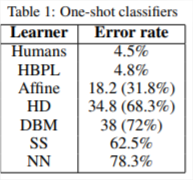
Hierarchial Bayesian Program Learning (HBPL), managed to have an overall error rate of 4.8% which is really impressive. Therefore the model used in the HBPL also takes in account of the order of strokes in the images which definitely helps to get better results.

If we want to compare our model, with another one using only pixels, another paper called 'Siamese Neural Networks for One-shot Image Recognition' (http://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) used Siamese network to do one-shot learning on the Omniglot Dataset.
They managed to get an overall error rate of 8% for 20-way classification as ours.
Yet, I believe their is still room for improvement for our model by using some of the following paths :
- Increase the duration of the training as we are only using a patience of 2 before decreasing our learning rate.
- Using Bayesian optimization to find a better set of hyperparameters
- Using an learning rate finder to find a better value when we restart our SGD.
- Select a better validation set. A more accurate validation set can be that instead of choosing whole alphabets, we could choose various characters from all the alphabets to keep in the validation set.
- Ensembling several models to reduce overfitting.
